# Explore the dwca format

In [1]:
from dwca.read import DwCAReader
from dwca.darwincore.utils import qualname as qn

import pandas as pd
from pathlib import Path

import json

import matplotlib.pyplot as plt
import numpy as np
import os
from abc import abstractmethod

from urllib.parse import unquote, urlparse
from pathlib import PurePosixPath
from PIL import Image

import asyncio, asyncssh, sys
from typing import TypedDict
from collections import defaultdict

import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
occurrences_path = Path("/home/george/codes/gbif-request/data/classif/mini/0013397-241007104925546.zip")

In [3]:
with DwCAReader(occurrences_path) as dwca:
    print(dwca.metadata)

<Element '{eml://ecoinformatics.org/eml-2.1.1}eml' at 0x7f354cf38b30>


In [4]:
dwca = DwCAReader(occurrences_path)

In [5]:
row = dwca.get_corerow_by_position(0)

Exploration first

In [27]:
lengths = []
for row in dwca:
    lengths+= [len(row.extensions)]

In [28]:
min(lengths), max(lengths)

(2, 11)

[]

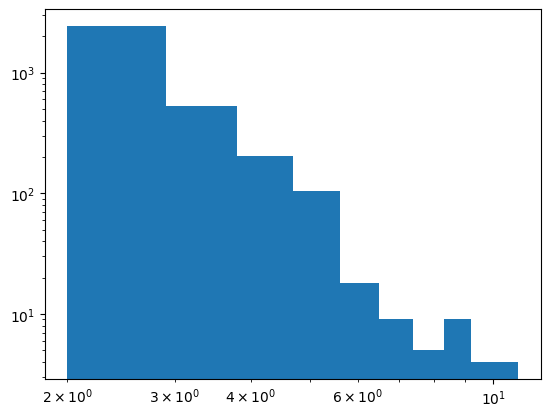

In [32]:
plt.hist(lengths)
plt.loglog()

In [10]:
dwca.extension_files

In [49]:
dwca.core_file.file_descriptor

In [45]:
row.descriptor.__dict__

{'created_from_file': False,
 'raw_element': <Element 'core' at 0x7fb6e8a92160>,
 'represents_corefile': True,
 'represents_extension': False,
 'type': 'http://rs.tdwg.org/dwc/terms/Occurrence',
 'file_location': 'occurrence.txt',
 'file_encoding': 'UTF-8',
 'id_index': 0,
 'coreid_index': None,
 'fields': [{'term': 'http://rs.tdwg.org/dwc/terms/geodeticDatum',
   'index': None,
   'default': 'WGS84'},
  {'term': 'http://rs.gbif.org/terms/1.0/gbifID', 'index': 0, 'default': None},
  {'term': 'http://purl.org/dc/terms/accessRights',
   'index': 1,
   'default': None},
  {'term': 'http://purl.org/dc/terms/bibliographicCitation',
   'index': 2,
   'default': None},
  {'term': 'http://purl.org/dc/terms/language', 'index': 3, 'default': None},
  {'term': 'http://purl.org/dc/terms/license', 'index': 4, 'default': None},
  {'term': 'http://purl.org/dc/terms/modified', 'index': 5, 'default': None},
  {'term': 'http://purl.org/dc/terms/publisher', 'index': 6, 'default': None},
  {'term': 'http:

In [35]:
def pretty_print(d):
    """Pretty print for dictionary.
    """
    d = {k.split('/')[-1]:v for k, v in d.items()}
    print(json.dumps(d, indent=4))

for i in range(len(row.extensions)):
    pretty_print(row.extensions[i].data)

{
    "gbifID": "1703229930",
    "type": "StillImage",
    "format": "image/png",
    "identifier": "https://inaturalist-open-data.s3.amazonaws.com/photos/12141435/original.png",
    "references": "https://www.inaturalist.org/photos/12141435",
    "title": "",
    "description": "",
    "source": "",
    "audience": "",
    "created": "2017-12-01T13:10:51Z",
    "creator": "anita-roberti4",
    "contributor": "",
    "publisher": "iNaturalist",
    "license": "http://creativecommons.org/licenses/by-nc/4.0/",
    "rightsHolder": "anita-roberti4"
}
{
    "gbifID": "1703229930",
    "accessRights": "",
    "bibliographicCitation": "",
    "language": "",
    "license": "http://creativecommons.org/licenses/by-nc/4.0/",
    "modified": "2017-12-03T19:08:22Z",
    "publisher": "",
    "references": "https://www.inaturalist.org/observations/9006574",
    "rightsHolder": "anita-roberti4",
    "type": "",
    "institutionID": "",
    "collectionID": "",
    "datasetID": "",
    "institutionCod

In [38]:
pretty_print(row.data)

{
    "geodeticDatum": "WGS84",
    "gbifID": "1703229930",
    "accessRights": "",
    "bibliographicCitation": "",
    "language": "",
    "license": "CC_BY_NC_4_0",
    "modified": "2017-12-03T19:08:22Z",
    "publisher": "",
    "references": "https://www.inaturalist.org/observations/9006574",
    "rightsHolder": "anita-roberti4",
    "type": "",
    "institutionID": "",
    "collectionID": "",
    "datasetID": "",
    "institutionCode": "iNaturalist",
    "collectionCode": "Observations",
    "datasetName": "iNaturalist research-grade observations",
    "ownerInstitutionCode": "",
    "basisOfRecord": "HUMAN_OBSERVATION",
    "informationWithheld": "",
    "dataGeneralizations": "",
    "dynamicProperties": "",
    "occurrenceID": "https://www.inaturalist.org/observations/9006574",
    "catalogNumber": "9006574",
    "recordNumber": "",
    "recordedBy": "anita-roberti4",
    "recordedByID": "",
    "individualCount": "",
    "organismQuantity": "",
    "organismQuantityType": "",

In [41]:
len(list(row.data.keys())), len(list(row.extensions[-1].data.keys()))

(224, 190)

In [43]:
for k in row.extensions[-1].data.keys():
    if k not in list(row.data.keys()):
        print(k.split('/')[-1])

associatedMedia
country
minimumElevationInMeters
maximumElevationInMeters
minimumDepthInMeters
maximumDepthInMeters
verbatimCoordinates
verbatimLatitude
verbatimLongitude
scientificNameAuthorship


Create a downloader file : merge occurrence and multimedia metadata in a Python dictionary

In [7]:
keys_mult = [
    # "gbifID",
    "type",
    "format",
    "identifier",
    "references",
    "created",
    "creator",
    "publisher",
    "license",
    "rightsHolder"
]

keys_occ = [
    "gbifID",

    # Recording metadata
    "basisOfRecord",
    "recordedBy",
    "continent",
    "countryCode",
    "stateProvince",
    "county",
    "municipality",
    "locality",
    "verbatimLocality",
    "decimalLatitude",
    "decimalLongitude",
    "coordinateUncertaintyInMeters", 
    "eventDate",
    "eventTime",

    # Copyrights metadata
    # "license",
    # "rightsHolder",


    # Individual metadata
    "sex",

    # Taxon metadata
    "acceptedNameUsageID", 
    "scientificName", 
    "kingdom", 
    "phylum", 
    "class", 
    "order", 
    "family", 
    "genus",
    "specificEpithet",
    "taxonRank",
    "taxonomicStatus",

    # Storage metadata
    "taxonKey",
    "acceptedTaxonKey",
    "datasetKey",
    "kingdomKey",
    "phylumKey",
    "classKey",
    "orderKey",
    "familyKey",
    "genusKey",
    "speciesKey",
    ]

keys_file = [
    "filename"
]

# Check if all the keys above are in the row metadata
row_keys = [k.split('/')[-1] for k in list(row.data.keys())]
for k in keys_occ:
    if k not in row_keys:
        print(k)

In [8]:
row.extensions[0].data

{'http://rs.gbif.org/terms/1.0/gbifID': '4953154697',
 'http://purl.org/dc/terms/type': 'StillImage',
 'http://purl.org/dc/terms/format': 'image/jpeg',
 'http://purl.org/dc/terms/identifier': 'https://inaturalist-open-data.s3.amazonaws.com/photos/182833891/original.jpeg',
 'http://purl.org/dc/terms/references': 'https://www.inaturalist.org/photos/182833891',
 'http://purl.org/dc/terms/title': '',
 'http://purl.org/dc/terms/description': '',
 'http://purl.org/dc/terms/source': '',
 'http://purl.org/dc/terms/audience': '',
 'http://purl.org/dc/terms/created': '2017-12-02T00:15:43Z',
 'http://purl.org/dc/terms/creator': 'Simon Oliver',
 'http://purl.org/dc/terms/contributor': '',
 'http://purl.org/dc/terms/publisher': 'iNaturalist',
 'http://purl.org/dc/terms/license': 'http://creativecommons.org/licenses/by-nc/4.0/',
 'http://purl.org/dc/terms/rightsHolder': 'Simon Oliver'}

In [9]:
images_metadata = {}

# Add keys for occurrence and multimedia
for k in keys_occ + keys_mult:
    images_metadata[k] = []

for row in dwca:

    # The last element of the extensions is the verbatim and is (almost) a duplicate of row data
    # And is thus not needed.
    extensions = row.extensions[:-1]

    for e in extensions:
        # Do not consider empty URLs
        identifier = e.data['http://purl.org/dc/terms/identifier']

        if identifier != '':
            # Add occurrence metadata
            # This is identical for all multimedia
            for k,v in row.data.items():
                k = k.split('/')[-1]
                if k in keys_occ:
                    images_metadata[k] += [v]

            # Add extension metadata
            for k,v in e.data.items():
                k = k.split('/')[-1]
                if k in keys_mult:
                    images_metadata[k] += [v]

            # Add image name for future download
            # Hashing of the image URL


In [10]:
# Save the metadata

# Solution 1 - with pandas
output_path = occurrences_path.parent / "tmp.parquet"
pd.DataFrame(images_metadata).to_parquet(output_path, engine='pyarrow', compression='gzip')

Remove empty speciesKey and co.

In [7]:
df = pd.read_parquet(path = occurrences_path.parent / "tmp.parquet")

In [ ]:
GBIF_KEYS = [
    "kingdomKey",
    "phylumKey",
    "classKey",
    "orderKey",
    "familyKey",
    "genusKey",
    "speciesKey",
]

df = df.loc[df['speciesKey'].notna() & (df['speciesKey'] != '')]

Remove duplicates

In [6]:
df = pd.read_parquet(path = occurrences_path.parent / "tmp.parquet")

In [13]:
# Remove the duplicates from images_metadata
# if a file is used several times all concerned rows are dropped.

# Solution 1 - no pandas, maybe overly complicated

# from collections import defaultdict

# def list_duplicates(seq):
#     """https://stackoverflow.com/a/5419576
#     """
#     tally = defaultdict(list)
#     for i,item in enumerate(seq):
#         tally[item].append(i)
#     return ((key,locs) for key,locs in tally.items() 
#                             if len(locs)>1)

# print(len(list(list_duplicates(images_metadata['identifier']))[0][1]))



# Solution 2 - pandas, much simpler

df = pd.DataFrame(images_metadata)
# print(df.duplicated(subset='identifier', keep=False).astype(int).sum())
df.drop_duplicates(subset='identifier', keep=False, inplace=True)
print(df.duplicated(subset='identifier', keep=False).astype(int).sum())


0


In [36]:
df.to_parquet(output_path, engine='pyarrow', compression='gzip')

Limit number of download per species

In [14]:
df = pd.read_parquet(path = occurrences_path.parent / "tmp.parquet")

In [15]:
len(df)

4589

In [35]:
max_num_images_per_species = 500
df = df.groupby('taxonKey').filter(lambda x: len(x) <= max_num_images_per_species)

In [33]:
# Get the scientific name of the maximum occurence
# df.iloc[df.groupby('taxonKey').count().idxmax()]
df[df['taxonKey'] == df['taxonKey'].value_counts().idxmax()]['scientificName'].iloc[0]
# df[df['taxonKey'] == df.groupby('taxonKey')['taxonKey'].count().idxmax()]['scientificName'].iloc[0]

'Operophtera brumata (Linnaeus, 1758)'

In [ ]:
df.to_parquet(output_path, engine='pyarrow', compression='gzip')

Download the images

In [6]:
df = pd.read_parquet(path = occurrences_path.parent / "tmp.parquet")

In [8]:
urls = df.identifier
formats = df.format 
species = df.speciesKey
occs = [(u,f,s) for u,f,s in zip(urls, formats, species)]

In [9]:
occs = [(row.identifier, row.format, row.speciesKey) for row in df.itertuples(index=False)]

Check the final df

In [6]:
occ_path = Path("/home/george/codes/gbifxdl/data/classif/mini/0013397-241007104925546.parquet")
df = pd.read_parquet(occ_path)

In [8]:
len(df)

4167

In [7]:
df.head()

,gbifID,basisOfRecord,recordedBy,continent,countryCode,stateProvince,county,municipality,locality,verbatimLocality,...,format,identifier,references,created,creator,publisher,license,rightsHolder,filename,set
0,4953154697,HUMAN_OBSERVATION,Simon Oliver,EUROPE,ES,Andalucía,,,,"Granada, Spain",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/182833891,2017-12-02T00:15:43Z,Simon Oliver,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Simon Oliver,5329da3d961e3896dcd7217a2368a12c16f661db.jpeg,test_ood
1,4953154697,HUMAN_OBSERVATION,Simon Oliver,EUROPE,ES,Andalucía,,,,"Granada, Spain",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/182833755,2017-12-02T00:14:34Z,Simon Oliver,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Simon Oliver,1b905dccc9918e3a4e8960c5a0484e0121ddcf2a.jpeg,test_ood
2,4946438829,HUMAN_OBSERVATION,jmra_royo,EUROPE,ES,Aragón,,,,"44500 Andorra, Teruel, España",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/427390547,2024-09-05T15:26:25Z,jmra_royo,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,0480a3fb8c3d64fa68519e44836e07d51575cd2a.jpeg,0
3,4946438829,HUMAN_OBSERVATION,jmra_royo,EUROPE,ES,Aragón,,,,"44500 Andorra, Teruel, España",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/427390556,2024-09-05T15:28:14Z,jmra_royo,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,cb95f7f2096b0c2a4757c60ae2cb31ba24f495f4.jpeg,3
4,4946438829,HUMAN_OBSERVATION,jmra_royo,EUROPE,ES,Aragón,,,,"44500 Andorra, Teruel, España",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/427390557,2024-09-05T15:26:52Z,jmra_royo,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,cc5c3d3e0767914df15a9da538c49645f1a083eb.jpeg,1


Postprocessing, remove duplicates

In [8]:
import pandas as pd

# Sample DataFrame
df = pd.DataFrame({
   'sha256': ['abc', 'abc', 'def', 'ghi', 'ghi', 'ghi'],
   'speciesKey': [1, 1, 2, 3, 4, 3]
})

# Step 1: Group by sha256 and apply the heuristic
def process_duplicates(group):
    if group['speciesKey'].nunique() == 1:
        # Only one speciesKey, keep one row
        return group.iloc[:1]
    else:
        # Multiple speciesKey, drop all duplicates
        return pd.DataFrame(columns=group.columns)

# Apply the function to each group of sha256
result = df.groupby('sha256', group_keys=False).apply(process_duplicates)

print(result)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
  sha256 speciesKey
0    abc          1
2    def          2


/tmp/ipykernel_681782/891429655.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('sha256', group_keys=False).apply(process_duplicates)


In [48]:
# Sample DataFrame
df = pd.DataFrame({
   'sha256': ['abc', 'abc', 'def', 'ghi', 'ghi', 'ghi'],
   'speciesKey': [1, 1, 2, 3, 4, 3],
   'filename': ['file1.jpg', 'file2.jpg', 'file3.jpg', 'file4.jpg', 'file5.jpg', 'file6.jpg']
})

# List to store removed sha256 values and files
removed_files = []

# Function to process duplicates based on heuristic
def process_duplicates(group):
    if group['speciesKey'].nunique() == 1:
        # Only one speciesKey, keep one row, delete the duplicates' files
        for index, row in group.iloc[1:].iterrows():  # Keep the first row, delete the rest
            file_path = f"{row['speciesKey']}/{row['filename']}"
            # if os.path.exists(file_path):
                # os.remove(file_path)
            removed_files.append(file_path)
        return group.iloc[:1]  # Keep only the first row
    
    else:
        # Multiple speciesKey, remove all rows and delete associated files
        for index, row in group.iterrows():
            file_path = f"{row['speciesKey']}/{row['filename']}"
            # if os.path.exists(file_path):
                # os.remove(file_path)
            removed_files.append(file_path)
        
        # Return an empty DataFrame for this group
        return pd.DataFrame(columns=group.columns)

# Apply the function to each group of sha256
result = df.groupby('sha256', group_keys=False).apply(process_duplicates, include_groups=True)

# Get the list of removed sha256 and files
removed_files_list = removed_files

# Output the cleaned DataFrame, removed sha256 list, and removed file paths
print("Cleaned DataFrame:")
print(result)

print("\nList of removed files:")
print(removed_files_list)

Cleaned DataFrame:
  sha256 speciesKey   filename
0    abc          1  file1.jpg
2    def          2  file3.jpg

List of removed files:
['1/file2.jpg', '3/file4.jpg', '4/file5.jpg', '3/file6.jpg']


/tmp/ipykernel_681782/3260974898.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('sha256', group_keys=False).apply(process_duplicates, include_groups=True)


In [ ]:
class FileManager:
    @abstractmethod
    def save(img, img_path):
        pass 

    @abstractmethod
    def remove(img_path):
        pass 

class LocalFileManager(FileManager):
    def save(img, img_path):
        with open(img_path, 'wb') as handler:
            handler.write(img)
    
    def remove(img_path):
        if os.path.exists(img_path):
            os.remove(img_path)


In [42]:
df = pd.read_parquet(path = occurrences_path.with_suffix('.parquet'))

In [43]:
len(df)

10

In [44]:
df.head()

,gbifID,basisOfRecord,recordedBy,continent,countryCode,stateProvince,county,municipality,locality,verbatimLocality,...,format,identifier,references,created,creator,publisher,license,rightsHolder,filename,set
0,4953154697,HUMAN_OBSERVATION,Simon Oliver,EUROPE,ES,Andalucía,,,,"Granada, Spain",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/182833891,2017-12-02T00:15:43Z,Simon Oliver,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Simon Oliver,5329da3d961e3896dcd7217a2368a12c16f661db.jpeg,test_ood
1,4953154697,HUMAN_OBSERVATION,Simon Oliver,EUROPE,ES,Andalucía,,,,"Granada, Spain",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/182833755,2017-12-02T00:14:34Z,Simon Oliver,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Simon Oliver,1b905dccc9918e3a4e8960c5a0484e0121ddcf2a.jpeg,test_ood
2,4946438829,HUMAN_OBSERVATION,jmra_royo,EUROPE,ES,Aragón,,,,"44500 Andorra, Teruel, España",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/427390547,2024-09-05T15:26:25Z,jmra_royo,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,0480a3fb8c3d64fa68519e44836e07d51575cd2a.jpeg,0
3,4946438829,HUMAN_OBSERVATION,jmra_royo,EUROPE,ES,Aragón,,,,"44500 Andorra, Teruel, España",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/427390556,2024-09-05T15:28:14Z,jmra_royo,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,cb95f7f2096b0c2a4757c60ae2cb31ba24f495f4.jpeg,3
4,4946438829,HUMAN_OBSERVATION,jmra_royo,EUROPE,ES,Aragón,,,,"44500 Andorra, Teruel, España",...,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/427390557,2024-09-05T15:26:52Z,jmra_royo,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,cc5c3d3e0767914df15a9da538c49645f1a083eb.jpeg,1


In [45]:
df['sha256'] 

KeyError: 'sha256'

In [31]:
df['sha256'] = np.arange(10)

In [37]:
df.to_parquet('/home/george/codes/gbifxdl/data/classif/mini/0013397-241007104925546.parquet', engine='pyarrow', compression='gzip')

In [4]:
url = 'sftp://erda:2222/datasets/tests'

PurePosixPath(unquote(urlparse(url).path))

PurePosixPath('/datasets/tests')

In [9]:
Path(urlparse(url).path)

PosixPath('/datasets/tests')

In [6]:
def get_image_paths(folder):
    """
    Recursively collect all image file paths in a folder.
    Returns a list of image file paths.
    """
    image_paths = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
    return image_paths

files = get_image_paths("/home/george/codes/gbifxdl/data/classif/mini/images")
len(files)

3349

In [6]:
remote_dir = "sftp://gmo@ecos.au.dk:@io.erda.au.dk/datasets/test3"
o = urlparse(remote_dir)
remote_dir = Path(o.path)
netloc = o.netloc
sftp_server = f"{o.scheme}://{o.netloc}"
print(sftp_server)

sftp://gmo@ecos.au.dk:@io.erda.au.dk


In [9]:
u,s=o.netloc.split(':@')

Check integrity of Parquet file

In [6]:
# df = pd.read_parquet("/home/george/codes/gbifxdl/data/classif/mini/0013397-241007104925546.parquet")
df1 = pd.read_parquet("/mnt/c/Users/au761367/OneDrive - Aarhus universitet/Codes/python/gbifxdl/data/classif/mini/0013397-241007104925546.parquet")
df2 = pd.read_parquet("/mnt/c/Users/au761367/OneDrive - Aarhus universitet/Codes/python/gbifxdl/data/classif/mini/0013397-241007104925546_processing_metadata.parquet")

In [11]:
df1[df1['continent']=='']

,gbifID,basisOfRecord,recordedBy,sex,lifeStage,eventDate,eventTime,continent,countryCode,stateProvince,...,type,format,identifier,references,created,creator,publisher,license,rightsHolder,url_hash
3933,1805381130,HUMAN_OBSERVATION,Katja Schulz,,Adult,2017-12-28T10:03,10:03:00-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.inaturalist.org/photos/12820777,2017-12-28T18:03:57Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,59149ffa0c90aa0f7884cdc87ea4f287427d8d83
3934,1805376232,HUMAN_OBSERVATION,Katja Schulz,,Adult,2017-12-31T10:50:52,10:50:52-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/2459175...,2017-12-31T18:51:17Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,2c4a5fcf80683d533460fd3c7fee61cfe56a7e65
3935,1805376232,HUMAN_OBSERVATION,Katja Schulz,,Adult,2017-12-31T10:50:52,10:50:52-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/2459181...,2017-12-31T18:50:59Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,85aff650694f9d05ce14f275f76d4ef7e02a8395
3936,1805376232,HUMAN_OBSERVATION,Katja Schulz,,Adult,2017-12-31T10:50:52,10:50:52-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/3942760...,2017-12-31T18:50:52Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,2412ca4d5dc8dcf9d66e847b2bbbb75572a1ac1b
3937,1805376232,HUMAN_OBSERVATION,Katja Schulz,,Adult,2017-12-31T10:50:52,10:50:52-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/3945836...,2017-12-31T18:51:03Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,207f0e5b789613381265716f6a8912c98f95e60f
3950,1802765017,HUMAN_OBSERVATION,Katja Schulz,MALE,Adult,2017-12-31T10:54:24,10:54:24-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/3945795...,2017-12-31T18:54:34Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,e2c395e49900cdb924e55d344c9eb909028c64fe
3951,1802765017,HUMAN_OBSERVATION,Katja Schulz,MALE,Adult,2017-12-31T10:54:24,10:54:24-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/2768021...,2017-12-31T18:54:24Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,77766428177e8eabc7b9ea2eaac0f5a6983a30bd
3952,1802765017,HUMAN_OBSERVATION,Katja Schulz,MALE,Adult,2017-12-31T10:54:24,10:54:24-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/2768022...,2017-12-31T18:54:01Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,e4007d4399e47c7306258f3afddc629b5121e3f0
3953,1802765017,HUMAN_OBSERVATION,Katja Schulz,MALE,Adult,2017-12-31T10:54:24,10:54:24-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/2459127...,2017-12-31T18:55:36Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja Schulz,83ab7a8416491ca39e7b5bdf6b378b7c3ed75b5e
3954,1802765017,HUMAN_OBSERVATION,Katja Schulz,MALE,Adult,2017-12-31T10:54:24,10:54:24-05:00,,ES,Comunidad Valenciana,...,StillImage,image/jpeg,https://inaturalist-open-data.s3.amazonaws.com...,https://www.flickr.com/photos/treegrow/2459125...,2017-12-31T18:56:52Z,Katja Schulz,iNaturalist,http://creativecommons.org/licenses/by/4.0/,Katja 

In [28]:
df1['url_hash'].tail(), df2['filename'].tail()

(4222    e7ef0af12578954bb294414964fbdecf99bc9dec
 4223    237e518bb91167dc44e8b32053db40a0dca2509d
 4224    758c937a1581b77db018ba171d391ad0f6edf8a2
 4225    f467ccfd6815060c78175b389a38a4c7ce7fe30b
 4226    6d822886f78dc5d219866645753e49cff537de5d
 Name: url_hash, dtype: object,
 4222    e7ef0af12578954bb294414964fbdecf99bc9dec.jpeg
 4223    237e518bb91167dc44e8b32053db40a0dca2509d.jpeg
 4224    758c937a1581b77db018ba171d391ad0f6edf8a2.jpeg
 4225    f467ccfd6815060c78175b389a38a4c7ce7fe30b.jpeg
 4226     6d822886f78dc5d219866645753e49cff537de5d.png
 Name: filename, dtype: object)

In [24]:
df[df.img_hash.duplicated(keep=False)]

,filename,img_hash,width,height,status,done
1225,f3007137348153994f2a511209fd94460b64c7f0.jpeg,659b0230fa47cfc0592f97255a3cca5391c7d1ec59ac6e...,800.0,529.0,uploading_success,True
1322,7c1b639adc2f758517454523365a93ff760dda81.jpeg,659b0230fa47cfc0592f97255a3cca5391c7d1ec59ac6e...,800.0,529.0,uploading_success,True
1351,None,None,NaN,NaN,downloading_failed,True
1442,8f07d2b5aff0d7b8fa3acc55c4a6f808d8fcc84e.jpeg,f4d1643a8d6e8691e4d530749cb3d2e299621ed4d24b93...,800.0,600.0,uploading_success,True
1443,2b5ae0dbc8652c01b83b58a3cf07eefc5e3f6711.jpeg,abf032abbccd30c46095b4331a323b504103bb46a0d7b8...,1536.0,2048.0,uploading_success,True
...,...,...,...,...,...,...
3543,None,None,NaN,NaN,downloading_failed,True
3544,None,None,NaN,NaN,downloading_failed,True
3545,None,None,NaN,NaN,downloading_failed,True
3897,a53813ba8f2130e8a1b9c8f7b53bbdff08d9d4e6.jpeg,039c10eaa45aa54abc551aa3a2d8be416c95f50bb6f221...,1014.0,761.0,uploading_success,True


In [15]:
df.keys()

Index(['filename', 'img_hash', 'width', 'height', 'status', 'done'], dtype='object')

In [19]:
len(df[df.status == 'downloading_failed'])

38

Try to stream the DWCA file to avoid loading it into memory

In [7]:
occurrences_path = Path("/mnt/c/Users/au761367/OneDrive - Aarhus universitet/Codes/python/gbifxdl/data/classif/mini/0013397-241007104925546.zip")

In [4]:
with DwCAReader(occurrences_path) as dwca:
    print(dwca.metadata)

<Element '{eml://ecoinformatics.org/eml-2.1.1}eml' at 0x7f7bd154f6a0>


In [5]:
dwca = DwCAReader(occurrences_path)

In [6]:
row = dwca.get_corerow_by_position(0)

SFTPClient connection

In [ ]:
from paramiko import SSHClient, AutoAddPolicy, SFTPClient, Transport, RSAKey

class SFTPHandler:
    def __init__(self, host, port, username, rsa_key_path=None, working_dir="/"):
        """
        Initialize the SFTPHandler with RSA key authentication.
        :param host: SFTP server hostname
        :param port: SFTP server port
        :param username: Username for authentication
        :param rsa_key_path: Path to the RSA private key file (optional)
        :param rsa_key_str: RSA private key as a string (optional)
        """
        self.transport = Transport((host, port))
        
        # Load RSA Key
        if rsa_key_path:
            rsa_key = RSAKey.from_private_key_file(rsa_key_path)
        else:
            raise ValueError("Either 'rsa_key_path' or 'rsa_key_str' must be provided.")
        
        # Connect with RSA Key
        self.transport.connect(username=username, pkey=rsa_key)
        self.sftp = SFTPClient.from_transport(self.transport)
        self.create_folder(working_dir)
        self.sftp.chdir(working_dir)
    
    def create_folder(self, folder):
        try:
            self.sftp.mkdir(folder)
        except IOError:
            pass  # Folder likely exists

    def upload_file(self, folder, filename, file_data):
        self.create_folder(folder)
        remote_path = os.path.join(folder, filename)
        self.sftp.putfo(file_data, remote_path)
        # with self.sftp.open(remote_path, "wb") as f:
        #     f.write(file_data)

    def close(self):
        self.sftp.close()
        self.transport.close()

sftp = SFTPHandler(
    host="io.erda.au.dk",
    port=2222,
    working_dir="datasets/test4",
    username="gmo@ecos.au.dk",
    rsa_key_path="/mnt/c/Users/au761367/.ssh/id_rsa",
)

In [12]:
img_path = "/mnt/c/Users/au761367/OneDrive - Aarhus universitet/Codes/python/gbifxdl/data/classif/mini/images/1011881/1c41c4a0ed1dc2c62fda5f30f3844bddb0f66ed5.jpeg"
img=Image.open(img_path)

In [13]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [16]:
with open(img_path, 'br') as img:
    sftp.upload_file("/", "1c41c4a0ed1dc2c62fda5f30f3844bddb0f66ed5.jpeg", img)

SFTPClient connection with async

In [3]:
async def run_client() -> None:
    async with asyncssh.connect(
        host="io.erda.au.dk",
        port=2222,
        username="gmo@ecos.au.dk",
        client_keys=["/mnt/c/Users/au761367/.ssh/id_rsa"]
        ) as conn:
        async with conn.start_sftp_client() as sftp:
            await sftp.get('datasets/test3/1011881/1c41c4a0ed1dc2c62fda5f30f3844bddb0f66ed5.jpeg')

try:
    asyncio.run(run_client())
except (OSError, asyncssh.Error) as exc:
    sys.exit('SFTP operation failed: ' + str(exc))

RuntimeError: asyncio.run() cannot be called from a running event loop

Test of TypedDict

In [4]:
class test(TypedDict):
    coucou: str = "h"
    num: int = None

def f(coucou, num):
    print(f"{coucou*num}")

t = test({"coucou":"hello ", "num":5})
# print(**t)
f(**t)

hello hello hello hello hello 


In [9]:
test(coucou="hello", num=5)

{'coucou': 'hello', 'num': 5}

In [5]:
test()

{}

Check metadata quality

In [8]:
pd.read_parquet(path="/mnt/c/Users/au761367/OneDrive - Aarhus universitet/Codes/python/gbifxdl/data/classif/mini/0013397-241007104925546_processing_metadata.parquet")

,gbifID,basisOfRecord,recordedBy,sex,lifeStage,eventDate,eventTime,continent,countryCode,stateProvince,...,publisher,license,rightsHolder,url_hash,filename,img_hash,width,height,status,done
0,4953154697,HUMAN_OBSERVATION,Simon Oliver,FEMALE,Adult,2017-12-01T16:14,16:14:00+01:00,EUROPE,ES,Andalucía,...,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Simon Oliver,5329da3d961e3896dcd7217a2368a12c16f661db,5329da3d961e3896dcd7217a2368a12c16f661db.jpeg,92c3e62dc6a08e3a9e762fe907416eebe0a695c1cf48f6...,2048,1536,uploading_success,True
1,4953154697,HUMAN_OBSERVATION,Simon Oliver,FEMALE,Adult,2017-12-01T16:14,16:14:00+01:00,EUROPE,ES,Andalucía,...,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,Simon Oliver,1b905dccc9918e3a4e8960c5a0484e0121ddcf2a,1b905dccc9918e3a4e8960c5a0484e0121ddcf2a.jpeg,45446601fe5a5a71f2c8f9273eac138efb49343a93d396...,2048,1536,uploading_success,True
2,4946438829,HUMAN_OBSERVATION,jmra_royo,,,2017-12-24T08:24,08:24:00+01:00,EUROPE,ES,Aragón,...,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,0480a3fb8c3d64fa68519e44836e07d51575cd2a,0480a3fb8c3d64fa68519e44836e07d51575cd2a.jpeg,f97b6776fa1b50cefc4fe2fbd70dd2cb7ff79640ccc276...,1806,2048,uploading_success,True
3,4946438829,HUMAN_OBSERVATION,jmra_royo,,,2017-12-24T08:24,08:24:00+01:00,EUROPE,ES,Aragón,...,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,cb95f7f2096b0c2a4757c60ae2cb31ba24f495f4,cb95f7f2096b0c2a4757c60ae2cb31ba24f495f4.jpeg,a72727ebc68a20e56233973a279a895dd5ff00902afeba...,1840,2017,uploading_success,True
4,4946438829,HUMAN_OBSERVATION,jmra_royo,,,2017-12-24T08:24,08:24:00+01:00,EUROPE,ES,Aragón,...,iNaturalist,http://creativecommons.org/licenses/by-nc/4.0/,jmra_royo,cc5c3d3e0767914df15a9da538c49645f1a083eb,cc5c3d3e0767914df15a9da538c49645f1a083eb.jpeg,a661478c9cbbb219162099aadbab369d83ae71108d6d16...,1588,2048,uploading_success,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,4934224794,HUMAN_OBSERVATION,User 140514,,Unknown,2017-12-07,,EUROPE,ES,Almería,...,,http://creativecommons.org/licenses/by-nc-nd/4.0/,Paco (Faluke),80397a94c453e33a9885594a673ed192717bf088,80397a94c453e33a9885594a673ed192717bf088.jpeg,10f6218862d2bf03656080c7f92440382de65226de869f...,792,800,uploading_success,True
66,4934224793,HUMAN_OBSERVATION,User 140514,,Unknown,2017-12-03,,EUROPE,ES,Almería,...,,http://creativecommons.org/licenses/by-nc-nd/4.0/,Paco (Faluke),144a3bca0223653f07267a601583852c78ba5b1a,144a3bca0223653f07267a601583852c78ba5b1a.jpeg,2600b53f08af54b8f7322e2a1754cdf26b55e25f66a5e7...,775,800,uploading_success,True
67,4934165256,HUMAN_OBSERVATION,User 140514,,Unknown,2017-12-17,,EUROPE,ES,Almería,...,,http://creativecommons.org/licenses/by-nc-nd/4.0/,Paco (Faluke),c7dd139e3f5b16deb6c8c5c9d27891f6c15e6b01,c7dd139e3f5b16deb6c8c5c9d27891f6c15e6b01.jpeg,d70516042919bb28af646f40e32a16166be152ec71827e...,749,800,uploading_success,True
68,4934165254,HUMAN_OBSERVATION,User 140514,,Unknown,2017-12-07,,EUROPE,ES,Almería,...,,http://creativecommons.org/licenses/by-nc-nd/4.0/,Paco (Faluke),6561936da159f8365548dc5596f65d07a74c9204,6561936da159f8365548dc5596f65d07a74c9204.jpeg,906f912b51e24fce67dd39015acca175c261073fc471f0...,800,680,uploading_success,True


Test parquet files

In [2]:
parquet_path="/mnt/c/Users/au761367/OneDrive - Aarhus universitet/Codes/python/gbifxdl/data/classif/mini/0013397-241007104925546.parquet"
batch_size = 10
parquet_iter_for_merge = pq.ParquetFile(parquet_path).iter_batches(batch_size=batch_size)
original_table = pa.Table.from_batches([next(parquet_iter_for_merge)])

In [3]:
original_table

pyarrow.Table
gbifID: string
basisOfRecord: string
recordedBy: string
sex: string
lifeStage: string
eventDate: string
eventTime: string
continent: string
countryCode: string
stateProvince: string
county: string
municipality: string
locality: string
verbatimLocality: string
decimalLatitude: string
decimalLongitude: string
coordinateUncertaintyInMeters: string
acceptedNameUsageID: string
scientificName: string
kingdom: string
phylum: string
class: string
order: string
family: string
genus: string
specificEpithet: string
taxonRank: string
taxonomicStatus: string
datasetKey: string
taxonKey: string
acceptedTaxonKey: string
kingdomKey: string
phylumKey: string
classKey: string
orderKey: string
familyKey: string
genusKey: string
speciesKey: string
type: string
format: string
identifier: string
references: string
created: string
creator: string
publisher: string
license: string
rightsHolder: string
url_hash: string
----
gbifID: [["4953154697","4953154697","4946438829","4946438829","4946438829